In [ ]:
from typing_extensions import TypedDict


class GraphState(TypedDict):
    question: str
    vectordb_status_flag: str
    context: list
    response: str


In [ ]:
import os
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

from langchain.chains.question_answering import load_qa_chain

from model_inference import embed_model, llm


def validate_database(state):
    """
    Validates the database state to ensure it is ready.
    
    Args:
        state (GraphState): The state of the graph database.
    
    Returns:
        update vectordb_status_flag
    """

    print("Validating database state...")
    persist_directory = os.path.join(os.getcwd(), "database", "chromadb")

    vector_store = Chroma(
        collection_name="example_collection",
        embedding_function=embed_model,
        persist_directory=persist_directory,  # Where to save data locally, remove if not necessary
    )


    all_ids = vector_store.get()["ids"]

    if len(all_ids) > 0:
        print("Database already prepared, skipping preparation.")
        return {"vectordb_status_flag": "true"}
    
    return {"vectordb_status_flag": "false"}



def prepare_database(state):
    """
    Prepares the database for use by validating its state.
    
    Args:
        state (GraphState): The state of the graph database.
    
    Returns:
        GraphState: The updated state of the graph database.
    """
    
    print("Preparing database...")
    try:
        persist_directory = os.path.join(os.getcwd(), "database", "chromadb")

        vector_store = Chroma(
            collection_name="example_collection",
            embedding_function=embed_model,
            persist_directory=persist_directory,  # Where to save data locally, remove if not necessary
        )
        
        # Load and chunk documents
        loader = TextLoader("database/sample_doc.txt")
        documents = loader.load()
        text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=20)
        texts = text_splitter.split_documents(documents)


        vector_store.add_documents(texts)

        print("Database prepared successfully.")
        status = "true"
    except Exception as e:
        print(f"Error preparing database: {e}")
        status = "false"
    
    return {"vectordb_status_flag": status}



def retrieve_context(state):
    """
    Retrieves context from the graph database based on the current state.
    
    Args:
        state (GraphState): The state of the graph database.
    
    Returns:
        str: The context retrieved from the graph database.
    """
    
    print("Retrieving context...")
    question = state["question"]


    persist_directory = os.path.join(os.getcwd(), "database", "chromadb")
    vector_store = Chroma(
            collection_name="example_collection",
            embedding_function=embed_model,
            persist_directory=persist_directory,  # Where to save data locally, remove if not necessary
        )
    
    # retrieved_documents = vector_store.similarity_search_with_relevance_scores(query=question, k=5)
    retriver = vector_store.as_retriever(search_type = "similarity_score_threshold", search_kwargs={"k": 5, "score_threshold": 0.5})
    relevant_doc = retriver.get_relevant_documents(question)

    return {"context": relevant_doc}


def generate_response(state):
    """
    Generates a response based on the current state of the graph database.
    
    Args:
        state (GraphState): The state of the graph database.
    
    Returns:
        str: The generated response.
    """
    
    print("Generating response...")

    question = state.get("question", "")
    context = state.get("context", "")


    chain = load_qa_chain(llm, chain_type="stuff")

    # response = chain.run(input_documents = context, question=question)
    response = chain.invoke({"input_documents": context, "question": question})

    return {"response": response["output_text"]}

# prompt | llm | parser

In [93]:
def route_question(state):
    """
    Routes the question to the appropriate function based on the current state.
    
    Args:
        state (GraphState): The state of the graph database.
    
    Returns:
        str: The response generated based on the routed question.
    """
    
    print("Routing question...")

    vectordb_status_flag = state.get("vectordb_status_flag", "false")

    if vectordb_status_flag == "false":
        return 'prepare_database'
    
    else:
        return "retrieve_context"

In [94]:
from langgraph.graph import END, StateGraph


workflow = StateGraph(GraphState)


workflow.add_node("validate_database", validate_database)
workflow.add_node("prepare_database", prepare_database)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("generate_response", generate_response)

workflow.set_entry_point("validate_database")


workflow.add_conditional_edges(
    "validate_database",
    route_question,
    {
        "prepare_database": "prepare_database",
        "retrieve_context": "retrieve_context"
    },
)

workflow.add_edge("prepare_database", "retrieve_context")
workflow.add_edge("retrieve_context", "generate_response")
workflow.add_edge("generate_response", END)


graph = workflow.compile()

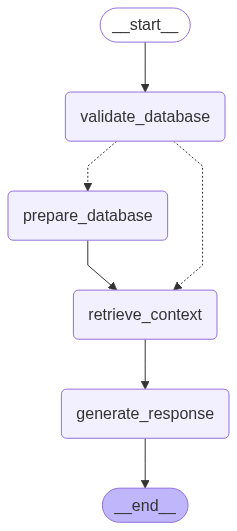

In [95]:
graph

In [98]:
output = graph.invoke(
    {
        "question": "who is a generalist?",
    }
)

Validating database state...
Routing question...
Preparing database...
Database already prepared, skipping preparation.
Retrieving context...
[Document(id='470bd9bd-8e3b-425e-8102-bc56b029b93b', metadata={'source': 'database/sample_doc.txt'}, page_content='In public policy and military strategy, generalists are typically preferred in leadership positions, where the ability to synthesize diverse information and make decisions across domains is crucial.'), Document(id='4687dea9-70e7-4c93-9acc-723e5cc7cc9c', metadata={'source': 'database/sample_doc.txt'}, page_content='In public policy and military strategy, generalists are typically preferred in leadership positions, where the ability to synthesize diverse information and make decisions across domains is crucial.'), Document(id='da58ae58-26ef-48a0-a773-0dfdbab4c626', metadata={'source': 'database/sample_doc.txt'}, page_content='Generalists are often better prepared to navigate unpredictable changes in the job market or technology landsca

In [100]:
output["response"]  # Access the response from the output dictionary

'A generalist is someone who has a broad set of skills and knowledge spanning multiple fields, often without in-depth mastery in any one of them. Generalists are typically preferred in leadership positions in public policy and military strategy due to their ability to synthesize diverse information and make decisions across various domains. They are also often better prepared to navigate unpredictable changes in the job market or technology landscape, as their learning agility allows them to pivot between roles and acquire new skills more readily than specialists.'

In [89]:
## integrating langfuse

In [ ]:
from langfuse import Langfuse
from langfuse.langchain import CallbackHandler

langfuse = Langfuse(
    public_key="your-public-key",
    secret_key="your-secret-key",
    host="https://cloud.langfuse.com"
)
langfuse_handler = CallbackHandler()


In [101]:
output = graph.invoke(
    {
        "question": "who is a generalist?",
    },
     config={"callbacks": [langfuse_handler]}
)

Validating database state...
Routing question...
Preparing database...
Database already prepared, skipping preparation.
Retrieving context...
[Document(id='470bd9bd-8e3b-425e-8102-bc56b029b93b', metadata={'source': 'database/sample_doc.txt'}, page_content='In public policy and military strategy, generalists are typically preferred in leadership positions, where the ability to synthesize diverse information and make decisions across domains is crucial.'), Document(id='4687dea9-70e7-4c93-9acc-723e5cc7cc9c', metadata={'source': 'database/sample_doc.txt'}, page_content='In public policy and military strategy, generalists are typically preferred in leadership positions, where the ability to synthesize diverse information and make decisions across domains is crucial.'), Document(id='da58ae58-26ef-48a0-a773-0dfdbab4c626', metadata={'source': 'database/sample_doc.txt'}, page_content='Generalists are often better prepared to navigate unpredictable changes in the job market or technology landsca

In [102]:
output["response"]  # Access the response from the output dictionary

'A generalist is someone who has a broad set of skills and knowledge spanning multiple fields, often without in-depth mastery in any one of them. Generalists are typically preferred in leadership positions in public policy and military strategy due to their ability to synthesize diverse information and make decisions across various domains. They are also often better prepared to navigate unpredictable changes in the job market or technology landscape.'

In [108]:
import requests
url = "http://localhost:7868/api/v1/run/005801d4-c7b8-4980-b957-85ccc7165929"  # The complete API endpoint URL for this flow

# Request payload configuration
payload = {
    "input_value": "who is a specialist ?",  # The input value to be processed by the flow
    "output_type": "chat",  # Specifies the expected output format
    "input_type": "chat"  # Specifies the input format
}

# Request headers
headers = {
    "Content-Type": "application/json"
}

try:
    # Send API request
    response = requests.request("POST", url, json=payload, headers=headers)
    response.raise_for_status()  # Raise exception for bad status codes

    # Print response
    print(response.text)

except requests.exceptions.RequestException as e:
    print(f"Error making API request: {e}")
except ValueError as e:
    print(f"Error parsing response: {e}")
    

{"session_id":"005801d4-c7b8-4980-b957-85ccc7165929","outputs":[{"inputs":{"input_value":"who is a specialist ?"},"outputs":[{"results":{"message":{"text_key":"text","data":{"timestamp":"2025-06-14 09:03:48 UTC","sender":"Machine","sender_name":"AI","session_id":"005801d4-c7b8-4980-b957-85ccc7165929","text":"A specialist is an individual who possesses deep knowledge and expertise in a narrowly defined domain. Specialists focus on a specific area of study or practice, often undergoing extensive training and experience to develop their skills. They are typically recognized for their concentrated expertise, which is essential in highly technical or complex fields, such as medicine, engineering, or law. Specialists often enjoy higher compensation and status within their professions due to the value placed on their rare skill sets.","files":[],"error":false,"edit":false,"properties":{"text_color":"","background_color":"","edited":false,"source":{"id":"OpenAIModel-kuAhW","display_name":"Open

In [ ]:
import ast 
import json

# output = ast.literal_eval(response.text)

# print(response.text)

json.loads(response.text)

{'session_id': '005801d4-c7b8-4980-b957-85ccc7165929',
 'outputs': [{'inputs': {'input_value': 'who is a specialist ?'},
   'outputs': [{'results': {'message': {'text_key': 'text',
       'data': {'timestamp': '2025-06-14 09:03:48 UTC',
        'sender': 'Machine',
        'sender_name': 'AI',
        'session_id': '005801d4-c7b8-4980-b957-85ccc7165929',
        'text': 'A specialist is an individual who possesses deep knowledge and expertise in a narrowly defined domain. Specialists focus on a specific area of study or practice, often undergoing extensive training and experience to develop their skills. They are typically recognized for their concentrated expertise, which is essential in highly technical or complex fields, such as medicine, engineering, or law. Specialists often enjoy higher compensation and status within their professions due to the value placed on their rare skill sets.',
        'files': [],
        'error': False,
        'edit': False,
        'properties': {'tex

: 